In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DiffusionSampler:
    """Handles sampling/inference from the trained diffusion model"""
    def __init__(self, model, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.model = model
        self.num_timesteps = num_timesteps
        self.device = device
        
        # Linear beta schedule (same as training)
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Precompute values for sampling
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        
        # Posterior variance for DDPM sampling
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
    
    @torch.no_grad()
    def ddpm_sample_step(self, x_t, t_int, current_age, target_age, reference_img):
        """Single DDPM sampling step"""
        batch_size = x_t.shape[0]
        
        # Create timestep tensor
        t = torch.full((batch_size,), t_int, dtype=torch.long, device=self.device)
        
        # Get model prediction
        noise_pred = self.model(x_t, t, current_age, target_age, reference_img)
        
        # Get parameters for this timestep
        alpha_t = self.alphas[t_int]
        alpha_cumprod_t = self.alphas_cumprod[t_int]
        beta_t = self.betas[t_int]
        
        # Predict x_0 from x_t and predicted noise
        sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod_t)
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1.0 - alpha_cumprod_t)
        
        # x_0 = (x_t - sqrt(1-alpha_cumprod) * noise) / sqrt(alpha_cumprod)
        pred_x0 = (x_t - sqrt_one_minus_alpha_cumprod_t * noise_pred) / sqrt_alpha_cumprod_t
        pred_x0 = torch.clamp(pred_x0, -1, 1)
        
        if t_int > 0:
            # Sample x_{t-1} using the posterior q(x_{t-1} | x_t, x_0)
            alpha_cumprod_prev = self.alphas_cumprod_prev[t_int]
            
            # Posterior mean coefficient for x_0
            coef_x0 = beta_t * torch.sqrt(alpha_cumprod_prev) / (1.0 - alpha_cumprod_t)
            # Posterior mean coefficient for x_t
            coef_xt = torch.sqrt(alpha_t) * (1.0 - alpha_cumprod_prev) / (1.0 - alpha_cumprod_t)
            
            posterior_mean = coef_x0 * pred_x0 + coef_xt * x_t
            
            # Add noise scaled by posterior variance
            posterior_variance = self.posterior_variance[t_int]
            noise = torch.randn_like(x_t)
            x_t_minus_1 = posterior_mean + torch.sqrt(posterior_variance) * noise
        else:
            # At t=0, return the predicted x_0 directly
            x_t_minus_1 = pred_x0
        
        return x_t_minus_1
    
    @torch.no_grad()
    def sample(self, reference_img, current_age, target_age, num_steps=None):
        """
        Generate aged/de-aged image
        
        Args:
            reference_img: Input image tensor (1, 3, H, W), normalized to [-1, 1]
            current_age: Current age tensor (1,)
            target_age: Target age tensor (1,)
            num_steps: Number of diffusion steps (default: self.num_timesteps)
        
        Returns:
            Generated image tensor (1, 3, H, W)
        """
        if num_steps is None:
            num_steps = self.num_timesteps
        
        # Start from random noise
        x_t = torch.randn_like(reference_img).to(self.device)
        
        # Reverse diffusion process
        for i in reversed(range(num_steps)):
            x_t = self.ddpm_sample_step(x_t, i, current_age, target_age, reference_img)
            
            if i % 100 == 0:
                print(f"Sampling step {i}/{num_steps}, x_t range: [{x_t.min():.3f}, {x_t.max():.3f}]")
        
        return x_t


In [3]:
def load_checkpoint(checkpoint_path, model, device='cuda'):
    """Load trained model checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"Cross-sectional loss: {checkpoint['loss_cross']:.4f}")
    print(f"Longitudinal loss: {checkpoint['loss_long']:.4f}")
    return model


def load_and_preprocess_image(image_path, size=256):
    """Load and preprocess image for the model"""
    transform = transforms.Compose([
        transforms.Resize((size, size), Image.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    
    # Handle both regular images and .npy files
    if image_path.endswith('.npy'):
        image = np.load(image_path)
        
        # Convert to uint8
        if image.dtype in [np.float32, np.float64]:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
        elif image.dtype != np.uint8:
            image = image.astype(np.uint8)
        
        # Handle channel order
        if image.ndim == 3:
            if image.shape[0] in [1, 3]:  # (C, H, W) format
                image = np.transpose(image, (1, 2, 0))
        elif image.ndim == 2:  # Grayscale
            image = np.expand_dims(image, axis=-1)
        
        # Convert to PIL
        image = np.ascontiguousarray(image)
        if image.shape[-1] == 1:
            image = Image.fromarray(image.squeeze(), mode='L').convert('RGB')
        else:
            image = Image.fromarray(image, mode='RGB')
    else:
        image = Image.open(image_path).convert('RGB')
    
    return transform(image).unsqueeze(0)  # Add batch dimension


def denormalize_image(tensor):
    """Convert normalized tensor back to displayable image"""
    # tensor: (1, 3, H, W) in range [-1, 1]
    img = tensor.squeeze(0).cpu()
    img = (img + 1) / 2  # [-1, 1] -> [0, 1]
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()
    return img


def visualize_age_transformation(original_img, generated_img, current_age, target_age, save_path=None):
    """Visualize original and generated images side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_img)
    axes[0].set_title(f'Original (Age: {current_age})', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(generated_img)
    axes[1].set_title(f'Generated (Age: {target_age})', fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()

/tmp/ipykernel_2515344/2277254484.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('epochs_attempt1/checkpoint_epoch_69.pt', map_location=device

DEBUGGING DIFFUSION SAMPLING

1. MODEL CHECK:
   Total parameters: 5,680,131
   Trainable parameters: 5,680,131
   Model device: cuda:0

2. DIFFUSION SCHEDULE CHECK:
   Betas device: cuda:0
   Betas range: [0.000100, 0.020000]
   Alphas_cumprod[0]: 0.999900 (should be ~1.0)
   Alphas_cumprod[-1]: 0.000040 (should be ~0.0)
   Num timesteps: 1000

3. INPUT CHECK:
   Image tensor shape: torch.Size([1, 3, 256, 256])
   Image tensor range: [-1.000, 1.000]
   Image tensor device: cuda:0
   Current age: tensor([32], device='cuda:0')
   Target age: tensor([42], device='cuda:0')

4. MODEL PREDICTION CHECK:
   t=  0: pred range [-9.141,  9.308], mean  0.002, std  2.069
   t=250: pred range [-6.186,  5.284], mean -0.003, std  1.249
   t=500: pred range [-5.101,  4.384], mean  0.002, std  1.029
   t=750: pred range [-4.955,  4.264], mean  0.003, std  0.999
   t=999: pred range [-4.936,  4.249], mean  0.005, std  0.997

5. SINGLE DENOISING STEP CHECK:
   Initial noise range: [-4.904, 4.368]
   Afte

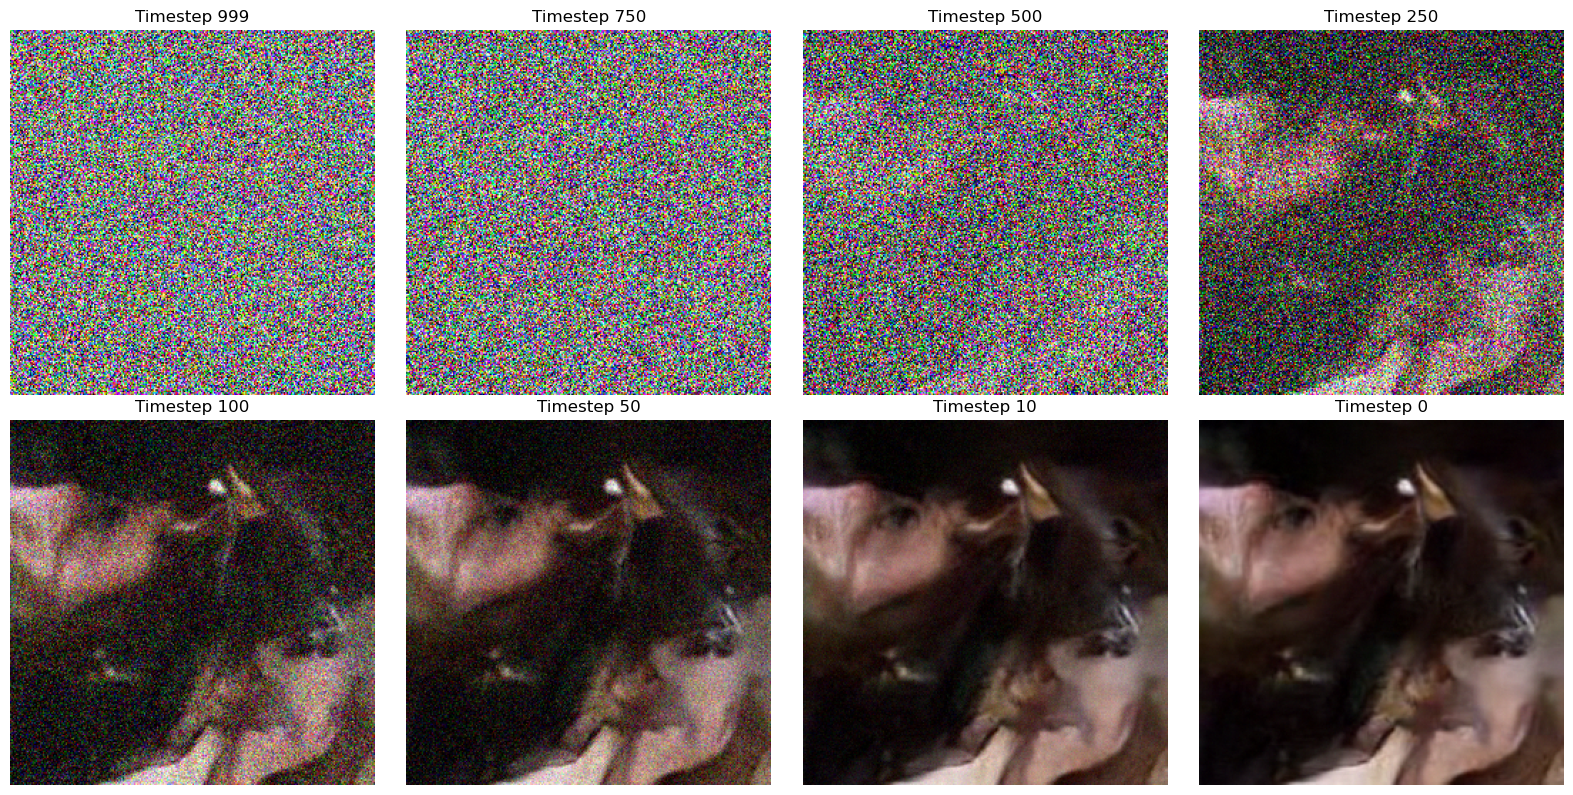

In [4]:

# Add these debugging functions

def debug_sampling_process(sampler, model, img_tensor, current_age, target_age, device):
    """
    Step through sampling and visualize what's happening at each stage
    """
    print("="*60)
    print("DEBUGGING DIFFUSION SAMPLING")
    print("="*60)
    
    model.eval()
    
    # Check 1: Model parameters
    print("\n1. MODEL CHECK:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model device: {next(model.parameters()).device}")
    
    # Check 2: Schedule parameters
    print("\n2. DIFFUSION SCHEDULE CHECK:")
    print(f"   Betas device: {sampler.betas.device}")
    print(f"   Betas range: [{sampler.betas.min():.6f}, {sampler.betas.max():.6f}]")
    print(f"   Alphas_cumprod[0]: {sampler.alphas_cumprod[0]:.6f} (should be ~1.0)")
    print(f"   Alphas_cumprod[-1]: {sampler.alphas_cumprod[-1]:.6f} (should be ~0.0)")
    print(f"   Num timesteps: {sampler.num_timesteps}")
    
    # Check 3: Input validation
    print("\n3. INPUT CHECK:")
    print(f"   Image tensor shape: {img_tensor.shape}")
    print(f"   Image tensor range: [{img_tensor.min():.3f}, {img_tensor.max():.3f}]")
    print(f"   Image tensor device: {img_tensor.device}")
    print(f"   Current age: {current_age}")
    print(f"   Target age: {target_age}")
    
    # Check 4: Test noise prediction at different timesteps
    print("\n4. MODEL PREDICTION CHECK:")
    with torch.no_grad():
        x_test = torch.randn_like(img_tensor)
        for t_test in [0, 250, 500, 750, 999]:
            t_tensor = torch.tensor([t_test], dtype=torch.long, device=device)
            noise_pred = model(x_test, t_tensor, current_age, target_age, img_tensor)
            print(f"   t={t_test:3d}: pred range [{noise_pred.min():6.3f}, {noise_pred.max():6.3f}], "
                  f"mean {noise_pred.mean():6.3f}, std {noise_pred.std():6.3f}")
    
    # Check 5: Single denoising step
    print("\n5. SINGLE DENOISING STEP CHECK:")
    x_t = torch.randn_like(img_tensor)
    print(f"   Initial noise range: [{x_t.min():.3f}, {x_t.max():.3f}]")
    
    with torch.no_grad():
        x_t_minus_1 = sampler.ddpm_sample_step(x_t, 999, current_age, target_age, img_tensor)
        print(f"   After 1 step (t=999): [{x_t_minus_1.min():.3f}, {x_t_minus_1.max():.3f}]")
        print(f"   Change magnitude: {(x_t - x_t_minus_1).abs().mean():.6f}")
    
    # Check 6: Run first 10 steps and track progress
    print("\n6. FIRST 10 DENOISING STEPS:")
    x_t = torch.randn_like(img_tensor)
    initial_range = (x_t.min().item(), x_t.max().item())
    
    with torch.no_grad():
        for i in reversed(range(990, 1000)):
            x_t_old = x_t.clone()
            x_t = sampler.ddpm_sample_step(x_t, i, current_age, target_age, img_tensor)
            change = (x_t - x_t_old).abs().mean().item()
            print(f"   Step {i}: range [{x_t.min():6.3f}, {x_t.max():6.3f}], change: {change:.6f}")
    
    final_range = (x_t.min().item(), x_t.max().item())
    print(f"\n   Initial range: {initial_range}")
    print(f"   Final range after 10 steps: {final_range}")
    
    # Check 7: Compare with training noise addition
    print("\n7. NOISE ADDITION CHECK (training process):")
    with torch.no_grad():
        clean_img = img_tensor
        t_add = torch.tensor([500], dtype=torch.long, device=device)
        
        sqrt_alpha_cumprod = torch.sqrt(sampler.alphas_cumprod[500])
        sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - sampler.alphas_cumprod[500])
        
        noise_added = torch.randn_like(clean_img)
        noisy_img = sqrt_alpha_cumprod * clean_img + sqrt_one_minus_alpha_cumprod * noise_added
        
        print(f"   Clean image range: [{clean_img.min():.3f}, {clean_img.max():.3f}]")
        print(f"   Noisy image (t=500): [{noisy_img.min():.3f}, {noisy_img.max():.3f}]")
        print(f"   sqrt_alpha_cumprod[500]: {sqrt_alpha_cumprod:.6f}")
        print(f"   sqrt_one_minus_alpha_cumprod[500]: {sqrt_one_minus_alpha_cumprod:.6f}")
        
        # Try to predict the noise
        noise_predicted = model(noisy_img, t_add, current_age, target_age, clean_img)
        noise_error = F.mse_loss(noise_predicted, noise_added)
        print(f"   Noise prediction MSE: {noise_error.item():.6f}")
        print(f"   (Should be close to training loss ~0.005)")
    
    print("\n" + "="*60)
    print("DIAGNOSIS COMPLETE")
    print("="*60)
    

def visualize_sampling_stages(sampler, model, img_tensor, current_age, target_age, device):
    """
    Visualize intermediate stages of the sampling process
    """
    model.eval()
    
    # Sample at specific checkpoints
    checkpoints = [999, 750, 500, 250, 100, 50, 10, 0]
    images = []
    
    x_t = torch.randn_like(img_tensor)
    
    with torch.no_grad():
        for i in reversed(range(1000)):
            if i in checkpoints:
                # Save current state
                img_vis = x_t.squeeze(0).cpu()
                img_vis = (img_vis + 1) / 2  # [-1,1] -> [0,1]
                img_vis = torch.clamp(img_vis, 0, 1)
                images.append((i, img_vis.permute(1, 2, 0).numpy()))
            
            x_t = sampler.ddpm_sample_step(x_t, i, current_age, target_age, img_tensor)
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, (timestep, img) in enumerate(images):
        axes[idx].imshow(img)
        axes[idx].set_title(f'Timestep {timestep}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('sampling_stages_debug.png', dpi=150, bbox_inches='tight')
    print("\nSaved visualization to 'sampling_stages_debug.png'")
    plt.show()


# ==================== USAGE ====================

if __name__ == "__main__":
    # Load your model and checkpoint
    from diffusion import AgeTransformationDiffusion
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AgeTransformationDiffusion(max_age=120).to(device)
    
    checkpoint = torch.load('epochs_attempt1/checkpoint_epoch_69.pt', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Create sampler
    
    sampler = DiffusionSampler(model, num_timesteps=1000, device=device)
    
    # Load a test image
   
    img_tensor = load_and_preprocess_image("/projects/standard/csci5561/shared/G8/data/face_age_Numpy/5887_032.npy").to(device)
    
    current_age = torch.tensor([32], dtype=torch.long, device=device)
    target_age = torch.tensor([42], dtype=torch.long, device=device)
    
    # Run diagnostics
    debug_sampling_process(sampler, model, img_tensor, current_age, target_age, device)
    
    # Visualize sampling stages
    visualize_sampling_stages(sampler, model, img_tensor, current_age, target_age, device)